# Leaf Classification


In this notebook, we will work on the [Kaggle Leaf Classification Challenge](https://www.kaggle.com/c/leaf-classification). We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

# Set up

1. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
2. Unpack the dataset in the current directory. You should have the following documents in your directory:
- images folder
- test.csv
- train.csv
- sample_submission.csv

### Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us save the path for later use. Just **replace this with your local path** if you're not running on colab.

In [6]:
drive_path = 'drive/My Drive/Deep_Learning/Leaf_Classification_Project/'

### Imports

In [7]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

# Understanding the data

Get the number of training and testing data and the repartition of the data between the different classes:

In [8]:
image_paths = glob.glob(drive_path+"images/*.jpg")
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv(drive_path+'train.csv')
train_images = [drive_path+'images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(drive_path+'test.csv')

Total Observations:	 1584


In [9]:
print("Nb samples for training:\t", len(train))
print("Nb samples for test:\t", len(test))
print("Attributes not present in both training and test data:\t", train.columns.symmetric_difference(test.columns))
train.groupby(['species'])['species'].count()

Nb samples for training:	 990
Nb samples for test:	 594
Attributes not present in both training and test data:	 Index(['species'], dtype='object')


species
Acer_Capillipes                 10
Acer_Circinatum                 10
Acer_Mono                       10
Acer_Opalus                     10
Acer_Palmatum                   10
                                ..
Tilia_Tomentosa                 10
Ulmus_Bergmanniana              10
Viburnum_Tinus                  10
Viburnum_x_Rhytidophylloides    10
Zelkova_Serrata                 10
Name: species, Length: 99, dtype: int64

Visualizing an image from each category:

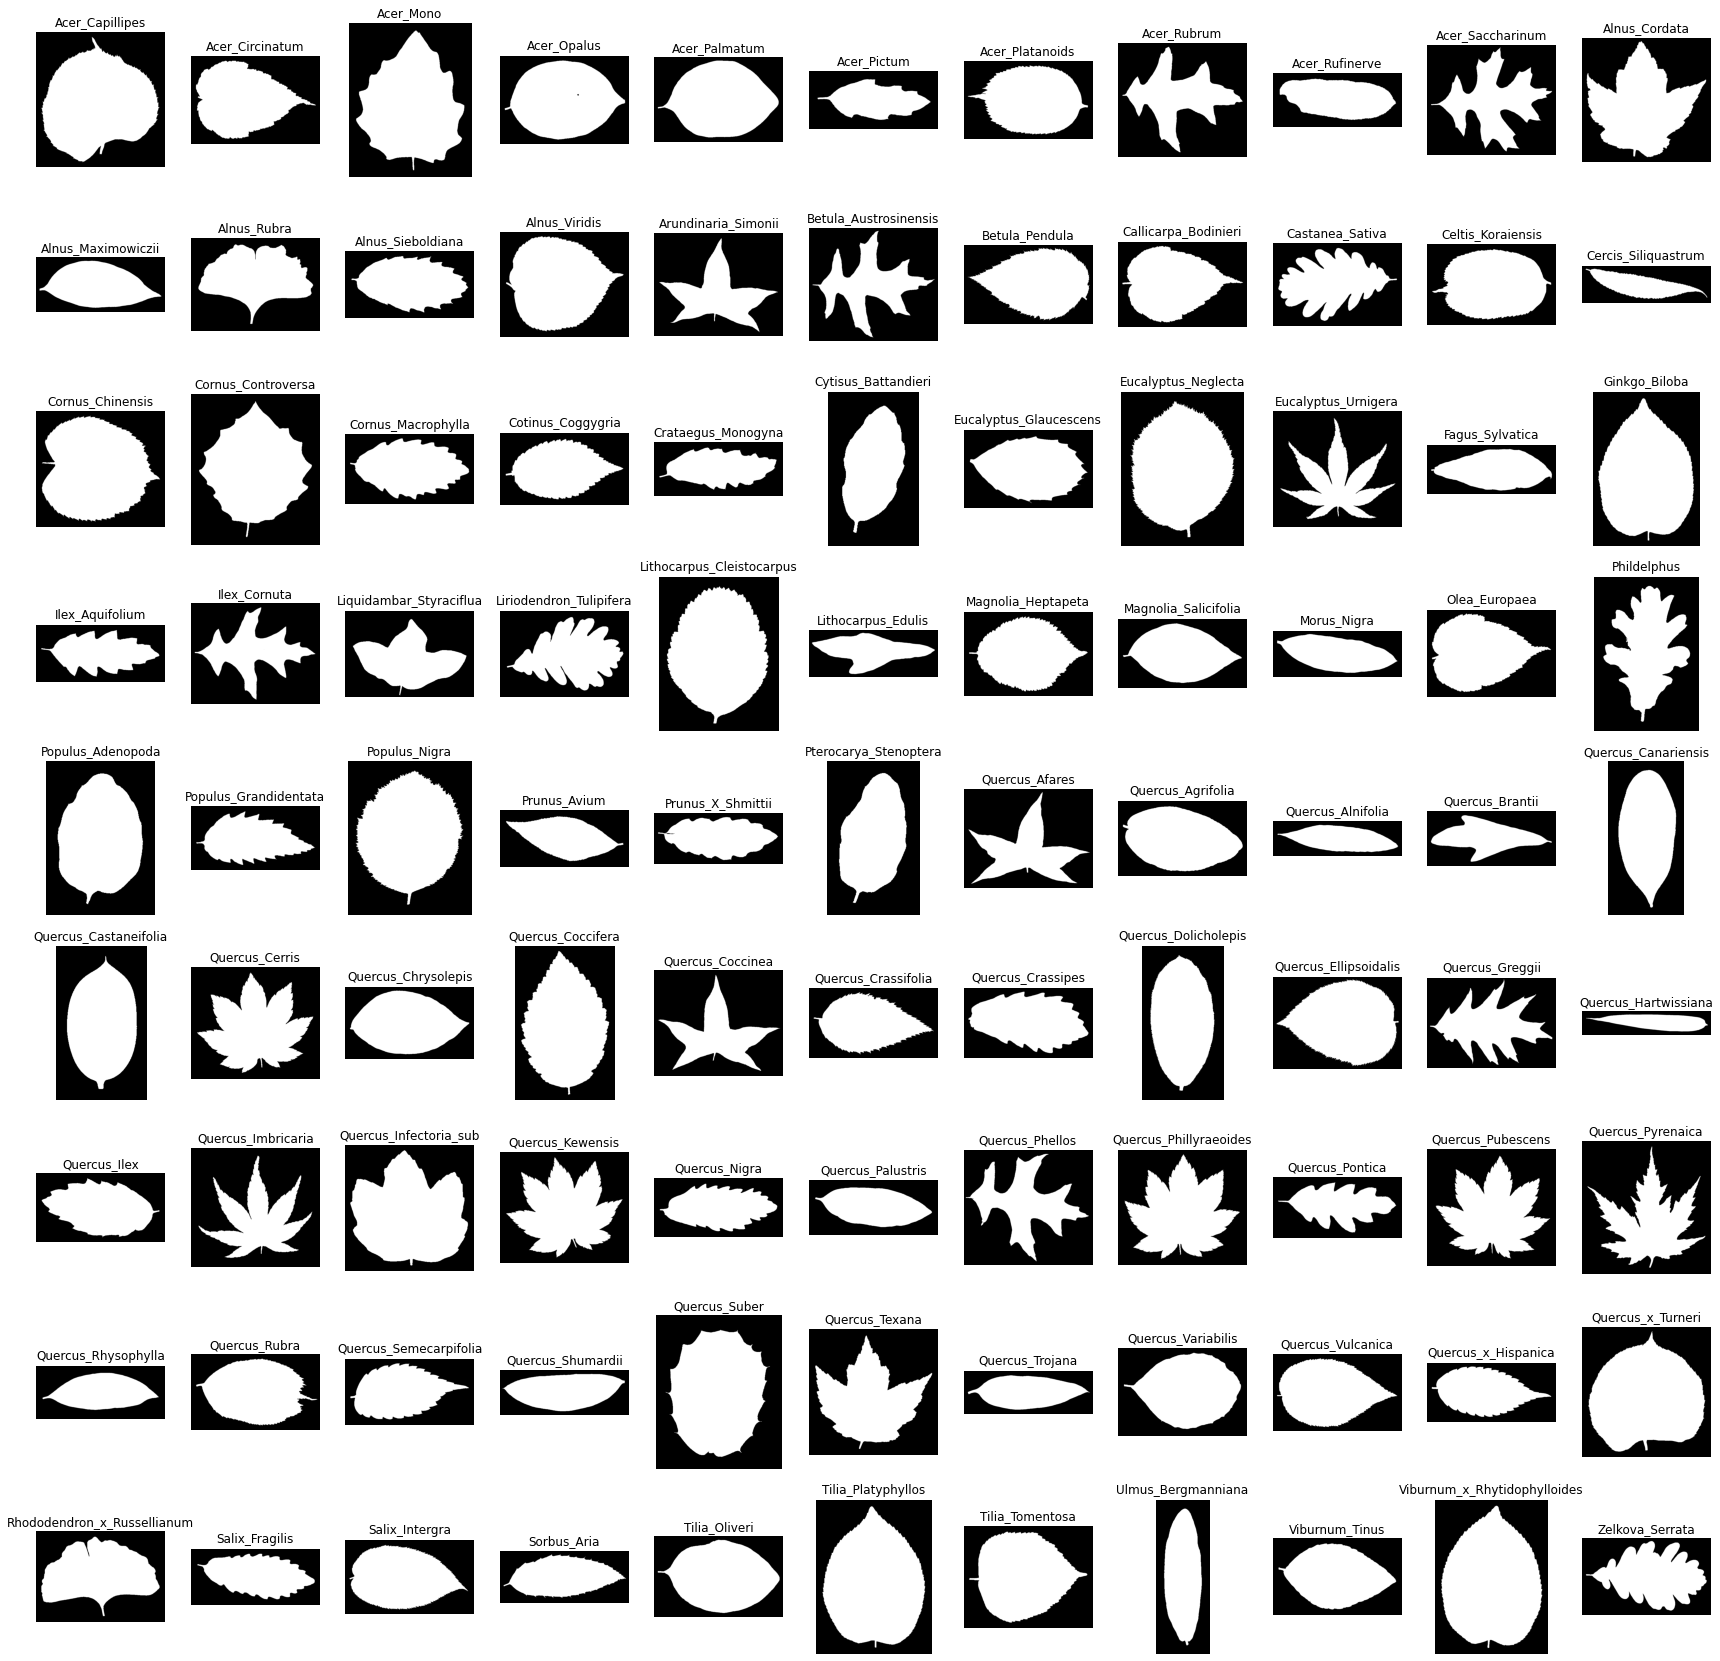

In [10]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(drive_path + 'images/{}.jpg'.format(i)) for i in species_examples]

# Display the images
nrows = 9
ncols = 11
fig,ax = plt.subplots(nrows,ncols,figsize=(30,30))

for i, ax in enumerate(ax.flat):
  image = imread(image_paths[i], as_gray=True)
  ax.imshow(image, cmap='gray')
  ax.set_title("%s" % (species[i]))
  ax.axis('off')
plt.show()

Investigating the other features:
* margin
* shape
* texture

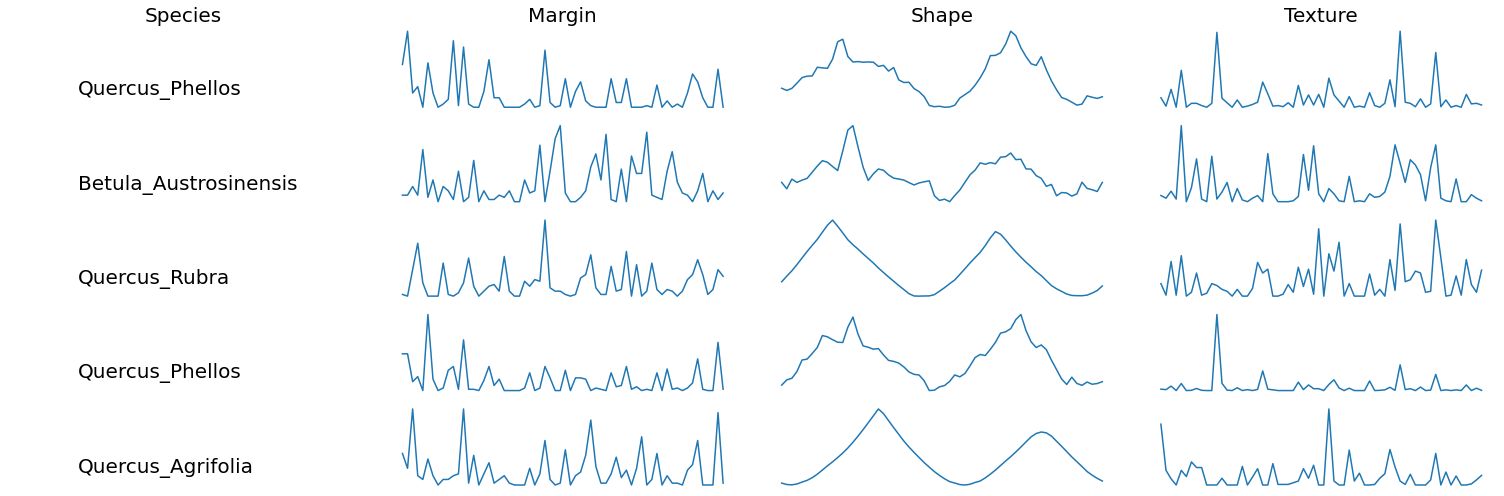

In [11]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data preparation



## Defining the data loader 
As a part of the data loader, we specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture.

In [12]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (32,32,1)
NUM_CLASSES = 99

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64

In [13]:
# Paths to data
TRAIN_PATH = drive_path + "train.csv" 
TEST_PATH = drive_path + "test.csv" 
IMAGE_PATHS = glob.glob(drive_path + "images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 32, 32, 1)0.279847
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 32, 32, 1)	0.280157
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [14]:
# import pickle

# # Dump the data into a pickle file
# with open(drive_path + '/data.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [15]:
# # Load the data from a pickle file
# with open(drive_path + '/data.pickle', 'rb') as f:
#     data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

In [16]:
batch_size = 128
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (128, 32, 32, 1)
	margins, (128, 64)
	shapes, (128, 64)
	textures, (128, 64)
	ts, (128, 99)

VALID
	images, (99, 32, 32, 1)
	margins, (99, 64)
	shapes, (99, 64)
	textures, (99, 64)
	ts, (99, 99)

TEST
	images, (128, 32, 32, 1)
	margins, (128, 64)
	shapes, (128, 64)
	textures, (128, 64)
	ids, 128


# Build the model

In [17]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [18]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


Defining the network architecture:

**Network Architecture**:

Three networks:

**1:** An image network consisting of 2 convolutional layers, 1 max pooling layer, and 2 fully connected layers

**2:** A margin and texture network of 2 fully connected layers

**3:** A shape network consisting of a GRU, and a fully connected layer

**Summary Network:** All three networks' final outputs are made to be 1000 using fully connected layers and then concatenated together. From there 2 more fully connected layers learn the mixture of the 3 model features that result in the best final classification.

In [19]:
height, width, channels = IMAGE_SHAPE

conv_out_channels = 16 # <-- Filters in your convolutional layer
kernel_size = 3        # <-- Kernel size
conv_stride = 1        # <-- Stride
conv_pad    = 0        # <-- Padding

drop_p      = 0.6      # <-- Drop percentage
 
# Keep track of features to output layer
features_cat_size = 1000 # <-- Number of features concatenated before output layer
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # ========Image Network ========
        
        # Convolutional Sequence 1
        self.conv_layer1 = Conv2d(in_channels = channels,
                                    out_channels = conv_out_channels,
                                    kernel_size = kernel_size,
                                    stride = conv_stride,
                                    padding = conv_pad)
        self.conv_layer2 = Conv2d(in_channels = conv_out_channels,
                                    out_channels = conv_out_channels,
                                    kernel_size = kernel_size,
                                    stride = conv_stride,
                                    padding = conv_pad)
        self.max_pool1 = MaxPool2d(kernel_size = 2, stride = 2)
        self.batch_norm1 = BatchNorm2d(conv_out_channels)
        self.drop_out1 = nn.Dropout2d(p=drop_p)

        # Linear Layer 1
        self.fc_1 = nn.Linear(3136, 2048)
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.drop_out2 = nn.Dropout(p=drop_p)

        # Linear Layer 2
        self.fc_2 = nn.Linear(2048, features_cat_size)
        self.batch_norm3 = nn.BatchNorm1d(features_cat_size)
        self.drop_out3 = nn.Dropout(p=drop_p)
        

        # ========Features Network ========
        self.fc_3 = Linear(in_features = 128, 
                           out_features = 512)
        self.batch_norm4 = BatchNorm1d(512)
        self.drop_out4 = nn.Dropout(p=drop_p)

        self.fc_4 = Linear(in_features = 512, 
                           out_features = features_cat_size)
        self.batch_norm5 = BatchNorm1d(features_cat_size)
        self.drop_out5 = nn.Dropout(p=drop_p)

        # ========Shape Network ========
        self.rnn_1 = GRU(NUM_FEATURES, 64, 2, batch_first = True)

        self.fc_5 = Linear(in_features = 64, 
                           out_features = features_cat_size)
        self.batch_norm6 = BatchNorm1d(features_cat_size)
        self.drop_out6 = nn.Dropout(p=drop_p)
        
        self.fc_6 = Linear(in_features = features_cat_size * 3, 
                           out_features = features_cat_size)

        self.batch_norm7 = BatchNorm1d(features_cat_size)
        self.drop_out7 = nn.Dropout(p=drop_p)

        self.l_out = Linear(in_features= features_cat_size,
                            out_features=NUM_CLASSES)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        
        # ========Image Network ========
        x_img = x_img.reshape((-1, channels, 32, 32))
    
        # Convolutional Sequence 1
        x = self.conv_layer1(x_img)
        x = self.conv_layer2(x)
        x = self.max_pool1(x)
        x = self.batch_norm1(relu(x))
        x = self.drop_out1(x)

        x = x.reshape(-1, 3136)

        x = self.fc_1(x)
        x = self.batch_norm2(relu(x))
        x = self.drop_out2(x)
        x = self.fc_2(x)
        x = self.batch_norm3(relu(x))
        features_img = self.drop_out3(x)
        
        # Append features to the list "features"
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##

        # ========Features Network ========
        x_feat = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors

        x = self.fc_3(x_feat)
        # x = self.dropout_1(x)
        x = self.batch_norm4(relu(x))
        x = self.drop_out4(x)
        x = self.fc_4(x)
        # x = self.dropout_2(x)
        x = self.batch_norm5(relu(x))
        x = self.drop_out5(x)
        
        features_vector = x

        features.append(features_vector)
        
        
        ## Use concatenated leaf features for RNN ##

        # ========Shape Network ========
        x,_ = self.rnn_1(x_shape)
        x = self.fc_5(x)
        x = self.batch_norm6(relu(x))
        features_rnn = self.drop_out6(x)
        
        # Append features to the list "features"
        features.append(features_rnn)

        # print(len(features[0]))
       
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        x = self.fc_6(features_final)
        x = self.batch_norm7(relu(x))
        x = self.drop_out7(x)
    
        out['out'] = softmax(self.l_out(x), dim = 1)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout2d(p=0.6, inplace=False)
  (fc_1): Linear(in_features=3136, out_features=2048, bias=True)
  (batch_norm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out2): Dropout(p=0.6, inplace=False)
  (fc_2): Linear(in_features=2048, out_features=1000, bias=True)
  (batch_norm3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out3): Dropout(p=0.6, inplace=False)
  (fc_3): Linear(in_features=128, out_features=512, bias=True)
  (batch_norm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out4): Dropout(p=0.6, inplace=False)
  (f

Defining the cross-entropy loss as the loss function:

In [20]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
criterion = nn.CrossEntropyLoss()  

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

Make sure the network is properly implemented:

In [21]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[0.0030, 0.0008, 0.0067,  ..., 0.0057, 0.0030, 0.0045],
        [0.0016, 0.0023, 0.0034,  ..., 0.0157, 0.0027, 0.0020],
        [0.0135, 0.0496, 0.0005,  ..., 0.0025, 0.0110, 0.0021],
        ...,
        [0.0014, 0.0090, 0.0177,  ..., 0.0015, 0.0109, 0.0140],
        [0.0075, 0.0015, 0.0053,  ..., 0.0497, 0.0021, 0.0039],
        [0.0079, 0.0138, 0.0046,  ..., 0.0136, 0.0045, 0.0026]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

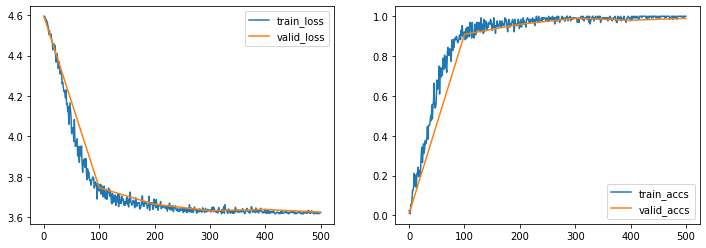

In [22]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 500
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

In [23]:
print("Train loss: {:.2f} accs: {:.2f}".format(train_loss[-1], train_accs[-1]))
print("Valid loss: {:.2f} accs: {:.2f}\n".format(valid_loss[-1], valid_accs[-1]))

Train loss: 3.62 accs: 1.00
Valid loss: 3.62 accs: 0.99



# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get the score.

In [24]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out.to('cpu'))
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

Make submission file:

In [25]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,1.374001e-09,5.106889e-10,4.189473e-11,2.308123e-06,3.304590e-10,1.934604e-10,3.059403e-09,2.128885e-10,3.698159e-09,...,1.198753e-10,4.878471e-09,2.611377e-07,1.818534e-09,4.065776e-07,3.966870e-10,4.606609e-11,1.000123e-08,2.072268e-10,1.031105e-11
1,7,3.213209e-08,1.440219e-08,6.643769e-09,4.249613e-05,2.424499e-09,7.032632e-08,8.607337e-06,2.310427e-08,1.026031e-07,...,3.102803e-09,1.620196e-08,4.146329e-08,4.713225e-08,3.476388e-08,1.647795e-06,9.211570e-08,1.602365e-07,1.392029e-08,1.277744e-05
2,9,1.316953e-09,9.996755e-01,8.014210e-08,8.801422e-07,6.810352e-05,2.259200e-06,1.928580e-07,4.103735e-07,3.383526e-06,...,2.899316e-09,9.655737e-09,2.977554e-08,3.656765e-08,1.360835e-09,5.020019e-07,5.564402e-09,5.970609e-09,4.963413e-09,2.123966e-06
3,12,5.701164e-09,7.388409e-07,5.390369e-08,1.177117e-08,1.269189e-09,1.536645e-08,4.174535e-07,5.249867e-08,5.685080e-06,...,1.916423e-07,3.947050e-08,6.229237e-08,3.478549e-10,2.720164e-08,1.104974e-06,7.477355e-05,3.055527e-09,2.959007e-08,4.918807e-06
4,13,7.090052e-10,1.757503e-07,3.383802e-10,6.163646e-10,1.009041e-07,2.259509e-10,7.614943e-08,1.199262e-09,9.571728e-07,...,4.270018e-07,5.444111e-10,5.760795e-07,1.601044e-09,3.313149e-06,3.187742e-07,6.135564e-07,1.701686e-08,4.990473e-10,1.245625e-10


## Credits
> The code is partially based on https://github.com/DeepLearningDTU (Deep Learning class in DTU).